### Rotary Positional Embedding

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, dim, max_len):
        super().__init__()
        pos = torch.arange(0, max_len, dtype=torch.float16).unsqueeze(-1) # [max_len, 1]
        ids = torch.arange(0, dim // 2, dtype=torch.float16) # [d_model // 2]
        theta = 10000 ** (-2*ids / dim) * pos
        self.sin = torch.sin(theta).repeat_interleave(2, dim=-1)
        self.cos = torch.cos(theta).repeat_interleave(2, dim=-1)

    def forward(self, q, k):
        bs, num_head, seq_len, head_dim = q.shape
        sin = self.sin.repeat(bs, num_head, 1, 1)
        cos = self.cos.repeat(bs, num_head, 1, 1)
        q1 = q
        q2 = torch.concat([-q[:, :, :, 1::2], q[:, :, :, ::2]], dim=-1)
        k1 = k
        k2 = torch.concat([-k[:, :, :, 1::2], k[:, :, :, ::2]], dim=-1)
        return q1 * cos + q2 * sin, k1 * cos + k2 * sin
    
d_model = 4
num_head = 2
head_dim = d_model // num_head
max_len = 6
rpe = RotaryPositionalEmbedding(head_dim, max_len)
q = torch.randn(2, num_head, max_len, head_dim)
k = torch.randn(2, num_head, max_len, head_dim)
q, k = rpe(q, k)
print(q.shape, k.shape)

torch.Size([2, 2, 6, 2]) torch.Size([2, 2, 6, 2])
torch.Size([2, 2, 6, 2]) torch.Size([2, 2, 6, 2])


### RoPE的远程衰减

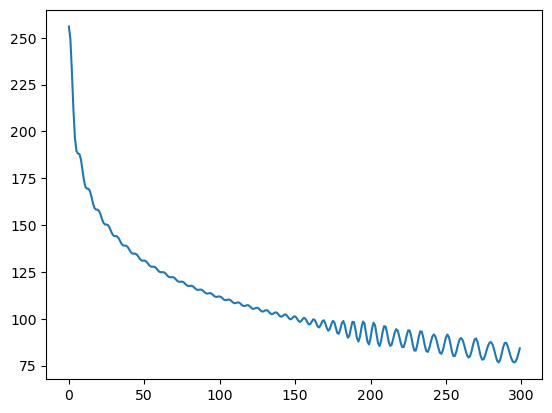

In [24]:
d_model = 512
i = torch.arange(0, d_model // 2)
theta = (10000) ** (-2 * i / d_model)
diff = torch.arange(0, 300).unsqueeze(-1)
cos = torch.cos(diff * theta)
import matplotlib.pyplot as plt
sum_cos = torch.sum(cos, dim=-1)
plt.plot(sum_cos)

In [1]:
import math

math.cos(1/10000), math.cos(2/10000)

(0.999999995, 0.9999999800000001)

### Self Attention

In [53]:
import math

class MultiheadSelfAttention(nn.Module):
    def __init__(self, num_head, hidden_dim):
        super().__init__()
        self.num_head = num_head
        self.hidden_dim = hidden_dim
        self.head_dim = hidden_dim // num_head
        self.qkv = nn.Linear(hidden_dim, hidden_dim * 3)
        self.out_proj = nn.Linear(hidden_dim, hidden_dim)
        self.attn_dropout = nn.Dropout(p=0.3)
        self.out_dropout = nn.Dropout(p=0.3)

    def forward(self, x, mask=None):
        bs, seq_len, _ = x.shape
        qkv = self.qkv(x).reshape(bs, seq_len, 3, self.num_head, self.head_dim).permute(2, 0, 3, 1, 4) # [3, bs, num_head, seq_len, head_dim]
        q, k, v = qkv[0], qkv[1], qkv[2]
        attention_score = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if mask is not None:
            attention_score.masked_fill_(mask==0, -1e9)
        attention_score = F.softmax(attention_score, dim=-1)
        attention_score = self.attn_dropout(attention_score)
        attention_score = torch.matmul(attention_score, v).transpose(1, 2).reshape(bs, seq_len, self.hidden_dim)
        output = self.out_proj(attention_score)
        output = self.out_dropout(output)
        return output
    
mhsa = MultiheadSelfAttention(4, 64)
x = torch.randn(2, 5, 64)
mhsa(x).shape

torch.Size([2, 5, 64])

In [66]:

class GroupQueryAttention(nn.Module):
    def __init__(self, num_head, hidden_dim, group_size=2):
        super().__init__()
        self.num_head = num_head
        self.hidden_dim = hidden_dim
        self.head_dim = hidden_dim // num_head
        self.group_size = group_size
        self.num_group = num_head // group_size
        self.q_proj = nn.Linear(hidden_dim, hidden_dim)
        self.k_proj = nn.Linear(hidden_dim, self.group_size * self.head_dim)
        self.v_proj = nn.Linear(hidden_dim, self.group_size * self.head_dim)
        self.out_proj = nn.Linear(hidden_dim, hidden_dim)
        self.attn_dropout = nn.Dropout(p=0.3)
        self.out_dropout = nn.Dropout(p=0.3)

    def forward(self, x, mask=None):
        bs, seq_len, _ = x.shape
        q = self.q_proj(x).reshape(bs, seq_len, self.num_head, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).reshape(bs, seq_len, self.group_size, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).reshape(bs, seq_len, self.group_size, self.head_dim).transpose(1, 2)
        grouped_query = torch.chunk(q, self.num_group, dim=1)
        attention_scores = []
        for query in grouped_query:
            attention_score = torch.matmul(query, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
            if mask is not None:
                attention_score.masked_fill_(mask==0, -1e9)
            attention_score = F.softmax(attention_score, dim=-1)
            attention_score = self.attn_dropout(attention_score)
            attention_score = torch.matmul(attention_score, v)
            attention_scores.append(attention_score)
        attention_score = torch.concat(attention_scores, dim=1).transpose(1, 2).reshape(bs, seq_len, self.hidden_dim)
        output = self.out_proj(attention_score)
        output = self.out_dropout(output)
        return output
    
mhsa = GroupQueryAttention(8, 64, 2)
x = torch.randn(2, 5, 64)
mhsa(x).shape

torch.Size([2, 5, 64])

In [7]:
import torch.nn as nn
import torch

class RoPEPositionalEncoding(nn.Module):
    """
    Rotary Position Encoding (RoPE) module.
    """

    def __init__(self, d_model, max_len=1000000, base=10000):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len
        self.base = base
        self.theta = torch.tensor(
            [base ** (-2 * (i // 2) / d_model) for i in range(d_model)]
        )

    def forward(self, positions):
        angles = positions.unsqueeze(-1) * self.theta
        sin_cos = torch.stack([angles.cos(), angles.sin()], dim=-1)
        return sin_cos.view(*sin_cos.shape[:-2], -1)
    
position = torch.arange(0, 512)

rope_pe = RoPEPositionalEncoding(d_model=1024)

pe = rope_pe(position)
pe.shape

def non_uniform_interpolation(pos_embed, extension_ratio, lambda_factors, n_hat):
    """
    Perform non-uniform interpolation on position embeddings as described in the LongRoPE paper.

    This function implements the two forms of non-uniformities:
    1. Varying RoPE dimensions (lambda_factors)
    2. Token positions (n_hat)

    The n_hat parameter represents the number of initial tokens to keep without interpolation,
    as described in the paper. This allows the model to maintain high-quality representations
    for the first n_hat tokens, which are often crucial for task performance.

    Args:
        pos_embed (torch.Tensor): Original position embeddings.
        extension_ratio (float): Ratio of target length to original length.
        lambda_factors (list): Lambda factors for each RoPE dimension.
        n_hat (int): Number of initial tokens to keep without interpolation.

    Returns:
        torch.Tensor: Interpolated position embeddings.
    """
    d_model = pos_embed.shape[-1]
    interpolated_pos = pos_embed.clone()

    for i in range(d_model // 2):
        # Apply different scaling based on token position
        mask = torch.arange(pos_embed.shape[-2], device=pos_embed.device) < n_hat
        scale = torch.where(
            mask,
            torch.ones_like(pos_embed[..., 0], device=pos_embed.device),
            1 / (lambda_factors[i] * extension_ratio),  # Use dimension-specific lambda factors
        )
        # Apply scaling to both sine and cosine components
        interpolated_pos[..., 2 * i] *= scale
        interpolated_pos[..., 2 * i + 1] *= scale

    return interpolated_pos

torch.Size([512, 2048])

In [20]:
import torch

def non_uniform_interpolation(pos_embed, extension_ratio, lambda_factors, n_hat):
    d_model = pos_embed.shape[-1]
    interpolated_pos = pos_embed.clone()

    for i in range(d_model // 2):
        mask = torch.arange(pos_embed.shape[-2], device=pos_embed.device) < n_hat
        scale = torch.where(
            mask,
            torch.ones_like(pos_embed[..., 0], device=pos_embed.device),
            1 / (lambda_factors[i] * extension_ratio)
        )
        print(mask)
        print(scale)
        interpolated_pos[..., 2 * i] *= scale
        interpolated_pos[..., 2 * i + 1] *= scale

    return interpolated_pos

# Define test inputs
pos_embed = torch.randn(1, 10, 4)  # 1 batch, 10 positions, 4 model dimensions
extension_ratio = 5.0
lambda_factors = [0.8, 0.8]  # For simplicity, using the same factor for both dimension pairs
n_hat = 5

# Call the function
output = non_uniform_interpolation(pos_embed, extension_ratio, lambda_factors, n_hat)
print(pos_embed)
print(output)


tensor([ True,  True,  True,  True,  True, False, False, False, False, False])
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500]])
tensor([ True,  True,  True,  True,  True, False, False, False, False, False])
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500]])
tensor([[[-0.4743, -0.2118,  1.1682,  0.6019],
         [-0.6564, -1.4026, -0.5887, -0.9835],
         [ 0.1771, -2.7645,  0.9062, -0.6906],
         [ 1.2431, -0.9780, -0.4634, -0.9300],
         [-0.0037, -2.0152, -1.6126,  0.3614],
         [ 3.1602, -0.1137, -0.1269,  0.1454],
         [ 0.1621, -0.0396, -0.5822, -0.1491],
         [ 1.8478,  0.6244,  1.2869, -0.7499],
         [ 0.4118,  0.8611,  1.2287,  0.3462],
         [ 0.0959, -0.1887, -0.6349, -1.0945]]])
tensor([[[-0.4743, -0.2118,  1.1682,  0.6019],
         [-0.6564, -1.4026, -0.5887, -0.9835],
         [ 0.1771, -2.7645,  0.9062, -0.6906],
         [ 1.2431, -0.9780, -

## Transformer

In [ ]:
from datasets import load_dataset

ds = load_dataset("botisan-ai/cantonese-mandarin-translations")

In [42]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

class PositionalEmbedding(nn.Module):
    def __init__(self, embed_dim, max_len=512, base=10000):
        super().__init__()
        pe = torch.zeros((max_len, embed_dim))
        pos = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * -(math.log(base) / embed_dim))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class GeGLU(nn.Module):
    def __init__(self, hidden_dim):
        super(GeGLU, self).__init__()
        self.proj1 = nn.Linear(hidden_dim, hidden_dim)
        self.proj2 = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        return F.gelu(self.proj1(x)) * self.proj2(x)

class SwiGLU(nn.Module):
    def __init__(self, hidden_dim):
        super(SwiGLU, self).__init__()
        self.proj1 = nn.Linear(hidden_dim, hidden_dim)
        self.proj2 = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        return F.silu(self.proj1(x)) * self.proj2(x)
    
class RMSNorm(nn.Module):
    def __init__(self, hidden_dim):
        super(RMSNorm, self).__init__()
        self.weights = nn.Parameter(torch.ones(hidden_dim), requires_grad=True)
        self.eps = 1e-8
        
    def forward(self, x):
        rms = torch.pow(x, 2).mean(dim=-1, keepdim=True)
        return self.weights * x / torch.rsqrt(rms + self.eps)

class SelfAttention(nn.Module):
    def __init__(self, embed_size, num_heads, attn_dropout=0., mask=None):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads
        self.qkv = nn.Linear(embed_size, embed_size * 3)
        self.out_proj = nn.Linear(embed_size, embed_size)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.mask = mask
    
    def forward(self, x):
        batch_size, seq_len, embed_size = x.shape
        qkv = self.qkv(x).reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attention_score = torch.matmul(q, k.transpose(-1, -2)) / self.head_dim ** 0.5
        if self.mask:
            mask = torch.tril(torch.ones(seq_len, seq_len)).to(device=x.device)
            attention_score = attention_score.masked_fill(mask==0, -1e9)
        attention_score = F.softmax(attention_score, dim=-1)
        attention_score = self.attn_dropout(attention_score)
        output = torch.matmul(attention_score, v).permute(0, 2, 1, 3).reshape(batch_size, seq_len, self.embed_size)
        return self.out_proj(output)

class CrossAttention(nn.Module):
    def __init__(self, embed_size, num_heads, attn_dropout=0., mask=None):
        super(CrossAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads
        self.kv = nn.Linear(embed_size, embed_size * 2)
        self.out_proj = nn.Linear(embed_size, embed_size)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.mask = mask
    
    def forward(self, q, x):
        batch_size, src_seq_len, _ = x.shape
        batch_size, tgt_seq_len, _ = q.shape
        kv = self.kv(x).reshape(batch_size, src_seq_len, 2, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]
        q = q.reshape(batch_size, tgt_seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        attention_score = torch.matmul(q, k.transpose(-1, -2)) / self.head_dim ** 0.5
        if self.mask:
            mask = torch.tril(torch.ones(tgt_seq_len, src_seq_len)).to(device=x.device)
            attention_score = attention_score.masked_fill(mask==0, -1e9)
        attention_score = F.softmax(attention_score, dim=-1)
        attention_score = self.attn_dropout(attention_score)
        output = torch.matmul(attention_score, v).permute(0, 2, 1, 3).reshape(batch_size, tgt_seq_len, self.embed_size)
        return self.out_proj(output)
    
class FFN(nn.Module):
    def __init__(self, hidden_dim, proj_dropout=0.):
        super(FFN, self).__init__()
        self.hidden_dim = hidden_dim
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            SwiGLU(hidden_dim * 4),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(proj_dropout)
        )

    def forward(self, x):
        return self.ffn(x)
    
class TransformerEncoderBlock(nn.Module):
    def __init__(self, hidden_dim, attn_dropout=0., proj_dropout=0., num_heads=8, mask=False):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.proj_dropout = proj_dropout
        self.attn_dropout = attn_dropout
        self.attn = SelfAttention(hidden_dim, num_heads, attn_dropout, mask=False)
        self.ffn = FFN(hidden_dim, proj_dropout)
        self.ln1 = RMSNorm(hidden_dim)
        self.ln2 = RMSNorm(hidden_dim)

    def forward(self, x):
        ## PostNorm
        x = self.ln1(x + self.attn(x))
        x = self.ln2(x + self.ffn(x))
        return x
    
class TransformerEncoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, attn_dropout=0., proj_dropout=0., num_heads=8, mask=False):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.layers = nn.ModuleList([TransformerEncoderBlock(hidden_dim, attn_dropout, proj_dropout, num_heads) for _ in range(num_layers)])

    def forward(self, x):
        layer_output = []
        for layer in self.layers:
            x = layer(x)
            layer_output.append(x)
        return layer_output
    
class TransformerDecoderBlock(nn.Module):
    def __init__(self, hidden_dim, attn_dropout=0., proj_dropout=0., num_heads=8):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.proj_dropout = proj_dropout
        self.attn_dropout = attn_dropout
        self.masked_attn = SelfAttention(hidden_dim, num_heads, attn_dropout, mask=True)
        self.cross_attn = CrossAttention(hidden_dim, num_heads, attn_dropout)
        self.ffn = FFN(hidden_dim, proj_dropout)
        self.ln1 = RMSNorm(hidden_dim)
        self.ln2 = RMSNorm(hidden_dim)
        self.ln3 = RMSNorm(hidden_dim)

    def forward(self, q, x):
        ## PostNorm
        x = self.ln1(x + self.masked_attn(x))
        x = self.ln2(x + self.cross_attn(q, x))
        x = self.ln3(x + self.ffn(x))
        return x
    
class TransformerDecoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, attn_dropout=0., proj_dropout=0., num_heads=8, mask=False):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.layers = nn.ModuleList([TransformerDecoderBlock(hidden_dim, attn_dropout, proj_dropout, num_heads) for _ in range(num_layers)])

    def forward(self, x, qs):
        for layer, q in zip(self.layers, qs):
            x = layer(q, x)
        return x
    
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, hidden_dim, num_layers, max_len=512, base=10000, attn_dropout=0., proj_dropout=0., num_heads=8):
        super().__init__()
        self.encoder_emb = nn.Embedding(src_vocab_size, hidden_dim)
        self.decoder_emb = nn.Embedding(tgt_vocab_size, hidden_dim)
        self.pe = PositionalEmbedding(hidden_dim, max_len, base)
        self.encoder = TransformerEncoder(hidden_dim, num_layers, attn_dropout, proj_dropout, num_heads)
        self.decoder = TransformerDecoder(hidden_dim, num_layers, attn_dropout, proj_dropout, num_heads)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, decoder_x):
        x = self.encoder_emb(x)
        x = self.pe(x)
        decoder_x = self.decoder_emb(decoder_x)
        decoder_x = self.pe(decoder_x)
        layer_output = self.encoder(x)
        decoder_output = self.decoder(decoder_x, layer_output)
        return decoder_output

In [43]:
x = torch.rand(1, 3, 32)
pos = PositionalEmbedding(32, 512, 10000)
print(pos(x).shape)

torch.Size([1, 3, 32])


In [46]:
f = Transformer(src_vocab_size=32, tgt_vocab_size=32, hidden_dim=32, num_layers=1)
x = torch.ones(1, 3, dtype=torch.long)
decoder_x = torch.ones(1, 1, dtype=torch.long)
f(x, decoder_x).shape

torch.Size([1, 3, 32])

## FastText

In [3]:
import fasttext